# HyperEuler on MNIST-trained Neural ODEs

In [2]:
import sys ; sys.path.append('..')
from torchdyn.models import *; from torchdyn import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.metrics.functional import accuracy
from tqdm import tqdm_notebook as tqdm
from src.custom_fixed_explicit import ButcherTableau, GenericExplicitButcher
from src.hypersolver import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# smaller batch_size; only needed for visualization. The classification model
# will not be retrained
batch_size=16
size=28
path_to_data='../../data/mnist_data'

all_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),

])

test_transforms = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,)),
])

train_data = datasets.MNIST(path_to_data, train=True, download=True,
                            transform=all_transforms)
test_data = datasets.MNIST(path_to_data, train=False,
                           transform=test_transforms)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Loading the pretrained Neural ODE 

In [5]:
func = nn.Sequential(nn.Conv2d(32, 46, 3, padding=1),
                     nn.Softplus(), 
                     nn.Conv2d(46, 46, 3, padding=1),
                     nn.Softplus(), 
                     nn.Conv2d(46, 32, 3, padding=1)
                     ).to(device)
ndes = []
for i in range(1):
    ndes.append(NeuralDE(func, 
                       solver='dopri5',
                       sensitivity='adjoint',
                       atol=1e-4,
                       rtol=1e-4,
                       s_span=torch.linspace(0, 1, 2)).to(device))
    #ndes.append(nn.Conv2d(32, 32, 3, padding=1)))

model = nn.Sequential(nn.BatchNorm2d(1),
                      Augmenter(augment_func=nn.Conv2d(1, 31, 3, padding=1)),
                      *ndes,
                      nn.AvgPool2d(28),
                      #nn.Conv2d(32, 1, 3, padding=1),
                      nn.Flatten(),                     
                      nn.Linear(32, 10)).to(device)


In [6]:
state_dict = torch.load('../pretrained_models/nde_mnist')

# remove state_dict keys for `torchdyn`'s Adjoint nn.Module (not used here)
copy_dict = state_dict.copy()
for key in copy_dict.keys(): 
    if 'adjoint' in key: state_dict.pop(key)
        
model.load_state_dict(state_dict)

<All keys matched successfully>

### Visualizing pretrained flows

In [7]:
x, y = next(iter(trainloader)); x = x.to(device)
for layer in model[:2]: x = layer(x)
model[2].nfe = 0
traj = model[2].trajectory(x, torch.linspace(0, 1, 50)).detach().cpu()
model[2].nfe 

/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torchdiffeq/_impl/misc.py:237: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


74

Pixel-flows of the Neural ODE, solved with `dopri5`

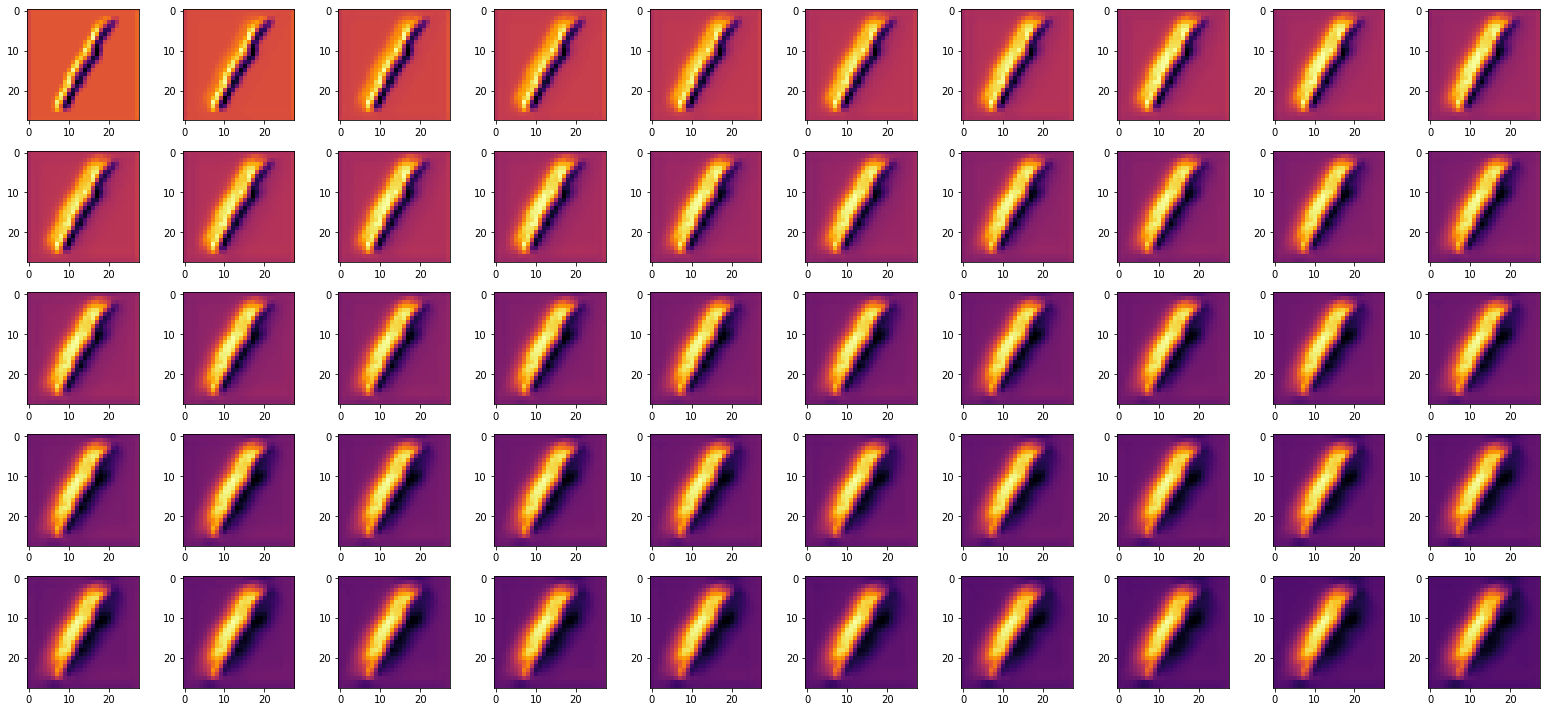

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(22, 10))
K = 4
for i in range(5):
    for j in range(10):
        im = axes[i][j].imshow(traj[i*5+j, K, 0], cmap='inferno')
fig.tight_layout(w_pad=0)

### Defining the HyperSolver class (-- HyperEuler version --)

In [9]:
tableau = ButcherTableau([[0]], [1], [0], [])
euler_solver = GenericExplicitButcher(tableau)

hypersolv_net = nn.Sequential(    
                nn.Conv2d(32+32+1, 32, 3, stride=1, padding=1),
                nn.PReLU(),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.PReLU(),
                nn.Conv2d(32, 32, 3, padding=1)).to(device)
#for p in hypersolv_net.parameters(): torch.nn.init.zeros_(p)

hs = HyperEuler(f=model[2].defunc, g=hypersolv_net)

x0 = torch.zeros(12, 32, 6, 6).to(device)
span = torch.linspace(0, 2, 10).to(device)

traj = model[2].trajectory(x0, span)
res_traj = hs.base_residuals(traj, span)
hyp_res_traj = hs.hypersolver_residuals(traj, span)
hyp_traj = hs.odeint(x0, span)

In [10]:
hyp_traj = hs.odeint(x0, span, use_residual=False).detach().cpu()
etraj = odeint(model[2].defunc, x0, span, method='euler').detach().cpu()

In [11]:
(hyp_traj - etraj).max()

tensor(0.)

### Training the Hypersolver

In [193]:
PHASE1_ITERS = 10 # num iters without swapping of the ODE initial condition (new sample)
ITERS = 15000
s_span = torch.linspace(0, 1, 10).to(device)

run_loss = 0.

# using test data for hypersolver training does not cause issues
# or task information leakage; the labels are not utilized in any way
it = iter(trainloader) 
X0, Y = next(it)
Y = Y.to(device)
X0 = model[:2](X0.to(device))

model[2].solver = 'dopri5'
traj  = model[2].trajectory(X0, s_span)
etraj = odeint(model[2].defunc, X0, s_span, method='euler')

opt = torch.optim.AdamW(hypersolv_net.parameters(), 1e-3, weight_decay=1e-8)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=ITERS, eta_min=5e-4)
for i in tqdm(range(ITERS)):     
    
    ds = s_span[1] - s_span[0]
    base_traj  = model[2].trajectory(X0, s_span)
    residuals = hs.base_residuals(base_traj, s_span).detach()
    # Let the model generalize to other ICs after PHASE1_ITERS
    if i > PHASE1_ITERS:
        if i % 10 == 0: # swapping IC 
            try:
                X0, _ = next(it)
            except:
                it = iter(trainloader)
                X0, _ = next(it)
            X0 = model[:2](X0.to(device))  
            model[2].solver = 'dopri5'
            base_traj  = model[2].trajectory(X0, s_span)
            residuals = hs.base_residuals(base_traj.detach(), s_span).detach()
        
    
    corrections = hs.hypersolver_residuals(base_traj.detach(), s_span)
    loss =  torch.norm(corrections - residuals.detach(), p='fro', dim=(3, 4)).mean() * ds**2 
     
    loss.backward()
    torch.nn.utils.clip_grad_norm_(hypersolv_net.parameters(), 1)
    if i % 10 == 0: print(f'\rLoss: {loss}', end='')
    opt.step()  
    sched.step()
    opt.zero_grad()

/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Loss: 7.7616429328918465


In [19]:
it = iter(testloader)
X0, _ = next(it)
X0 = model[:2](X0.to(device))
steps = 10
s_span = torch.linspace(0, 1, steps)
# dopri traj
model[2].solver = 'dopri5'
traj = model[2].trajectory(X0, s_span).detach().cpu()
# euler traj
model[2].solver = 'euler'
etraj = model[2].trajectory(X0, s_span).detach().cpu()
#etraj = hs.odeint(X0, s_span, use_residual=False).detach().cpu()

straj = hs.odeint(X0, s_span, use_residual=True).detach().cpu()

/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/torchdiffeq/_impl/misc.py:237: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Evolution of absolute error: [Above] HyperEuler, [Below] Euler

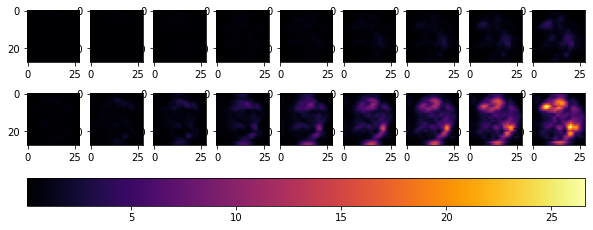

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=steps-1, figsize=(10, 4))
K = 1
vmin = min(torch.abs(straj[steps-1,:]-traj[steps-1,:]).mean(1)[K].min(), 
           torch.abs(etraj[steps-1,:]-traj[steps-1,:]).mean(1)[K].min())
vmax = max(torch.abs(straj[steps-1,:]-traj[steps-1,:]).mean(1)[K].max(), 
           torch.abs(etraj[steps-1,:]-traj[steps-1,:]).mean(1)[K].max())

for i in range(steps-1):
    im = axes[0][i].imshow(torch.abs(straj[i+1,:]-traj[i+1,:]).mean(1)[K], cmap='inferno', vmin=vmin, vmax=vmax)
for i in range(steps-1):
    im = axes[1][i].imshow(torch.abs(etraj[i+1,:]-traj[i+1,:]).mean(1)[K], cmap='inferno', vmin=vmin, vmax=vmax)  
fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal')
#tikz.save('MNIST_interpolation_AE_plot.tex')

Evolution of absolute error: HyperEuler (alone). Greater detail

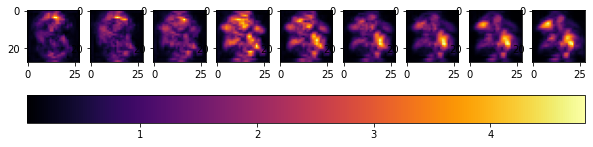

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=steps-1, figsize=(10, 4))
for i in range(steps-1):
    im = axes[i].imshow(torch.abs(straj[i+1,:]-traj[i+1,:]).mean(1)[K], cmap='inferno')
fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal')

### Evaluating ODE solution error

In [ ]:
x = []
# NOTE: high GPU mem usage for generating data below for plot (on GPU)
# consider using less batches (and iterating) or performing everything on CPU
for i in range(5):
    x_b, _ = next(it)
    x += [model[:2](x_b.to(device))]
x = torch.cat(x); x.shape

In [ ]:
STEPS = range(8, 50)

euler_avg_error, euler_std_error = [], []
hyper_avg_error, hyper_std_error = [], []
midpoint_avg_error, midpoint_std_error = [], []
rk4_avg_error, rk4_std_error = [], []

for step in tqdm(STEPS):
    s_span = torch.linspace(0, 1, step)
    # dopri traj
    model[2].solver = 'dopri5'
    traj = model[2].trajectory(x, s_span).detach().cpu()
    # euler traj
    model[2].solver = 'euler'
    etraj = model[2].trajectory(x, s_span).detach().cpu()
    # hypersolver
    s_span = torch.linspace(0, 1, step)
    straj = hs.odeint(x, s_span, use_residual=True).detach().cpu()
    #midpoint
    model[2].solver = 'midpoint'
    s_span = torch.linspace(0, 1, step//2)
    mtraj = model[2].trajectory(x, s_span).detach().cpu()
    
    #midpoint
    model[2].solver = 'rk4'
    s_span = torch.linspace(0, 1, step//4)
    rtraj = model[2].trajectory(x, s_span).detach().cpu()
       
    # errors
    euler_error = torch.abs((etraj[-1].detach().cpu() - traj[-1].detach().cpu()) / traj[-1].detach().cpu()).sum(1)
    hyper_error = torch.abs((straj[-1].detach().cpu() - traj[-1].detach().cpu()) / traj[-1].detach().cpu()).sum(1)
    midpoint_error = torch.abs((mtraj[-1].detach().cpu() - traj[-1].detach().cpu()) / traj[-1].detach().cpu()).sum(1)
    rk4_error = torch.abs((rtraj[-1].detach().cpu() - traj[-1].detach().cpu()) / traj[-1].detach().cpu()).sum(1)
    
    # mean, stdev
    euler_avg_error += [euler_error.mean().item()] ; euler_std_error += [euler_error.mean(dim=1).mean(dim=1).std(0).item()]
    hyper_avg_error += [hyper_error.mean().item()] ; hyper_std_error += [hyper_error.mean(dim=1).mean(dim=1).std(0).item()]
    midpoint_avg_error += [midpoint_error.mean().item()] ; midpoint_std_error += [midpoint_error.mean(dim=1).mean(dim=1).std(0).item()]
    rk4_avg_error += [rk4_error.mean().item()] ; rk4_std_error += [rk4_error.mean(dim=1).mean(dim=1).std(0).item()]

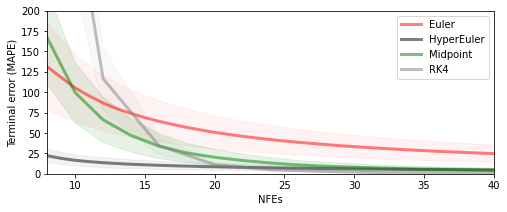

In [26]:
euler_avg_error, euler_std_error = np.array(euler_avg_error), np.array(euler_std_error)
hyper_avg_error, hyper_std_error = np.array(hyper_avg_error), np.array(hyper_std_error)
midpoint_avg_error, midpoint_std_error = np.array(midpoint_avg_error), np.array(midpoint_std_error)
rk4_avg_error, rk4_std_error = np.array(rk4_avg_error), np.array(rk4_std_error)

range_steps = range(8, 50, 1)
fig, ax = plt.subplots(1, 1); fig.set_size_inches(8, 3)
ax.plot(range_steps, euler_avg_error, color='red', linewidth=3, alpha=0.5)
ax.fill_between(range_steps, euler_avg_error-euler_std_error, euler_avg_error+euler_std_error, alpha=0.05, color='red')

ax.plot(range_steps, hyper_avg_error, c='black', linewidth=3, alpha=0.5)
ax.fill_between(range_steps, hyper_avg_error+hyper_std_error, hyper_avg_error-hyper_std_error, alpha=0.05, color='black')

# start from 10 steps, balance the steps 
mid_range_steps = range(8, 50, 2)
ax.plot(mid_range_steps, midpoint_avg_error[::2], color='green', linewidth=3, alpha=0.5)
ax.fill_between(mid_range_steps, midpoint_avg_error[::2]-midpoint_std_error[::2], midpoint_avg_error[::2]+midpoint_std_error[::2], alpha=0.1, color='green')

# start from 10 steps, balance the steps 
mid_range_steps = range(8, 50, 4)
ax.plot(mid_range_steps, rk4_avg_error[::4], color='gray', linewidth=3, alpha=0.5)
ax.fill_between(mid_range_steps, rk4_avg_error[::4]-rk4_std_error[::4], rk4_avg_error[::4]+rk4_std_error[::4], alpha=0.05, color='gray')


ax.set_ylim(0, 200)
ax.set_xlim(8, 40)
ax.legend(['Euler', 'HyperEuler', 'Midpoint', 'RK4'])
ax.set_xlabel('NFEs')
ax.set_ylabel('Terminal error (MAPE)')